Figures saved: figure1.png, figure1.pdf
Date range: Dec 2023 - Mar 2024


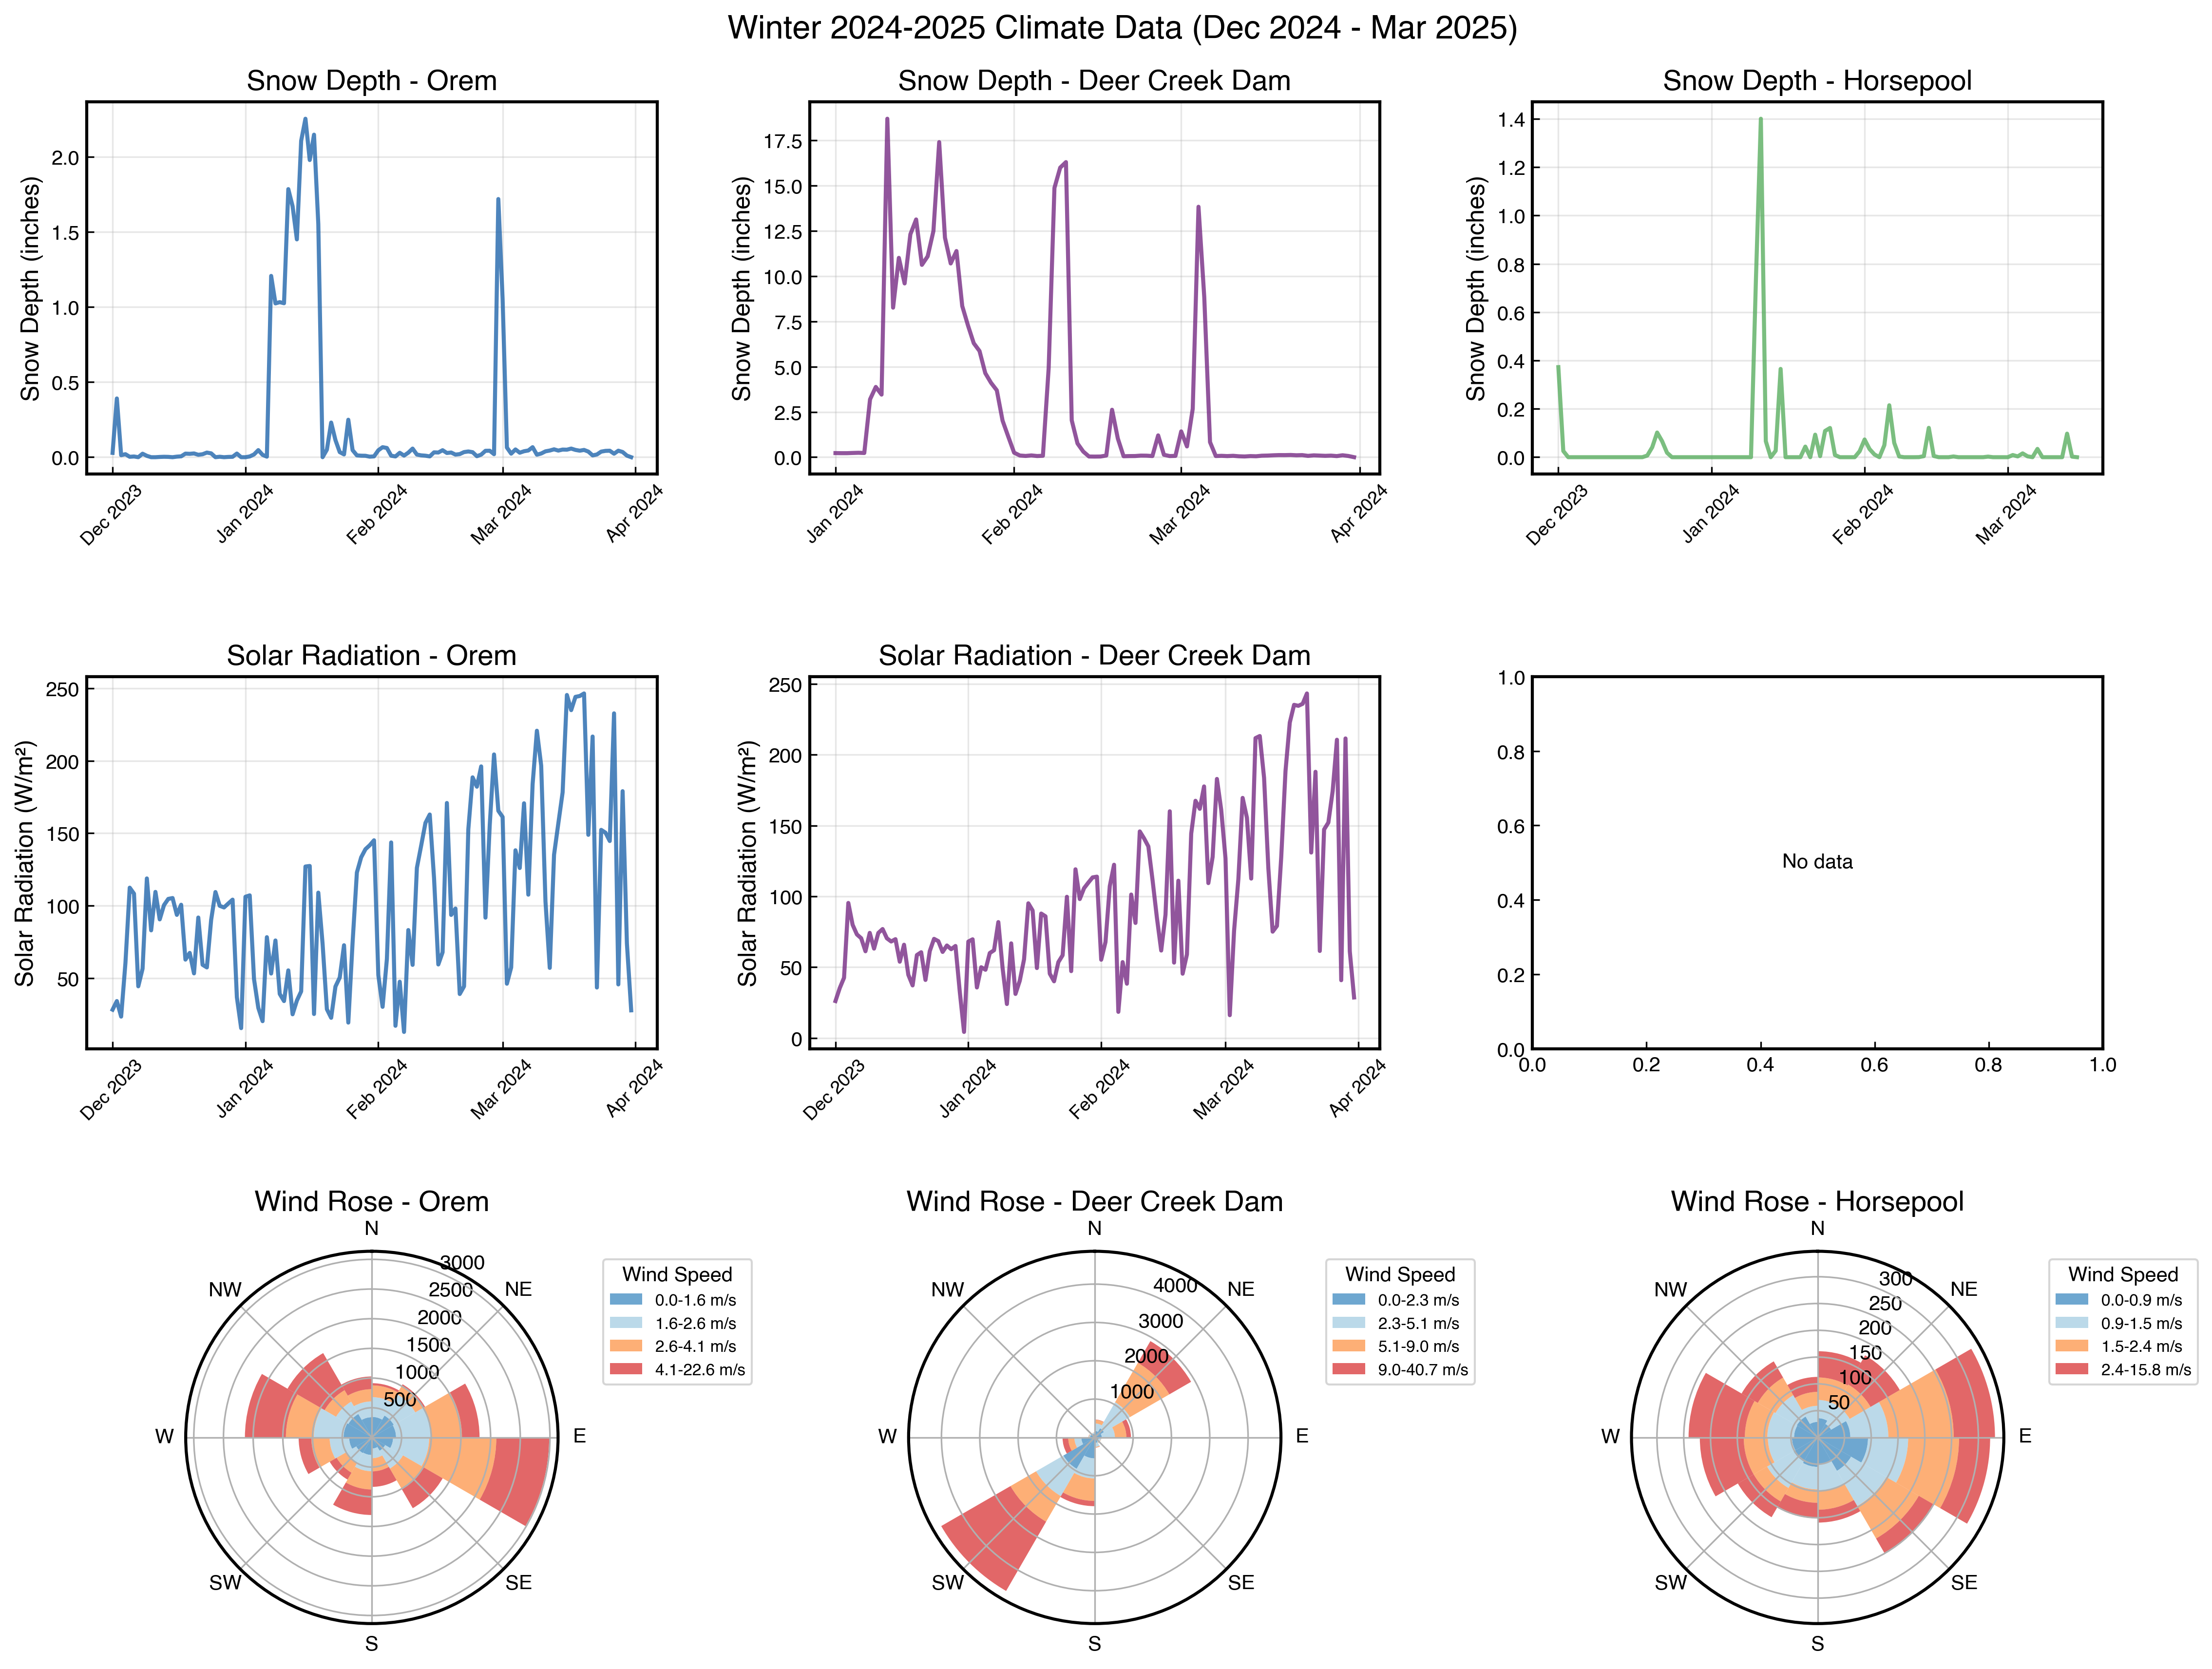

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import warnings

warnings.filterwarnings('ignore')


class ClimateDataLoader:
    def __init__(self, csv_file_path=None, xlsx_file_path=None, start_date=None, end_date=None):
        self.csv_file = csv_file_path
        self.xlsx_file = xlsx_file_path
        self.start_date = pd.to_datetime(start_date) if start_date else None
        self.end_date = pd.to_datetime(end_date) if end_date else None
        self.winter_months = [12, 1, 2, 3]
        # Reorder stations: Orem, Deer Creek Dam, Horsepool
        self.stations = {'UTORM': 'Orem', 'UTDCD': 'Deer Creek Dam', 'HORS': 'Horsepool'}
        self.target_variables = ['snow_depth', 'wind_direction', 'solar_radiation', 'wind_speed']

    def filter_winter_months(self, df):
        if df.empty:
            return df

        # Filter by winter months
        df_winter = df[df['date_time'].dt.month.isin(self.winter_months)].copy()

        # Apply date range filter if specified
        if self.start_date is not None:
            df_winter = df_winter[df_winter['date_time'] >= self.start_date]
        if self.end_date is not None:
            df_winter = df_winter[df_winter['date_time'] <= self.end_date]

        return df_winter

    def load_csv_data(self):
        if not self.csv_file:
            return pd.DataFrame()

        df_csv = pd.read_csv(self.csv_file)
        df_csv['date_time'] = pd.to_datetime(df_csv['date_time'])
        if df_csv['date_time'].dt.tz is not None:
            df_csv['date_time'] = df_csv['date_time'].dt.tz_localize(None)

        csv_variables = ['snow_depth', 'wind_direction', 'solar_radiation', 'wind_speed']
        df_filtered = df_csv[
            (df_csv['stid'].isin(['UTDCD', 'UTORM'])) &
            (df_csv['variable'].isin(csv_variables))
            ].copy()

        return self.filter_winter_months(df_filtered)

    def load_xlsx_data(self):
        if not self.xlsx_file:
            return pd.DataFrame()

        df_xlsx = pd.read_excel(self.xlsx_file, sheet_name='all data', header=[2, 3], index_col=0, parse_dates=True)

        if 'Hors' not in df_xlsx.columns.get_level_values(0):
            return pd.DataFrame()

        df_hors = df_xlsx['Hors'].copy().reset_index()
        df_hors.rename(columns={df_hors.columns[0]: 'date_time'}, inplace=True)

        if df_hors['date_time'].dt.tz is not None:
            df_hors['date_time'] = df_hors['date_time'].dt.tz_localize(None)

        # Convert to long format
        var_map = {'winddir': 'wind_direction', 'windspd': 'wind_speed',
                   'snowdepth': 'snow_depth', 'SW_incoming': 'solar_radiation'}

        long_format_data = []
        for xlsx_var, standard_var in var_map.items():
            if xlsx_var in df_hors.columns:
                subset = df_hors[['date_time', xlsx_var]].copy()
                subset['stid'] = 'HORS'
                subset['variable'] = standard_var
                subset['value'] = subset[xlsx_var]
                subset = subset[['stid', 'date_time', 'variable', 'value']].dropna(subset=['value'])
                long_format_data.append(subset)

        if long_format_data:
            df_long = pd.concat(long_format_data, ignore_index=True)
            return self.filter_winter_months(df_long)

        return pd.DataFrame()

    def load_data(self):
        csv_data = self.load_csv_data()
        xlsx_long = self.load_xlsx_data()

        datasets = [df for df in [csv_data, xlsx_long] if not df.empty]
        if not datasets:
            raise ValueError("No data loaded")

        self.data = pd.concat(datasets, ignore_index=True)
        self.data['date_time'] = pd.to_datetime(self.data['date_time'])
        self.data = self.data[self.data['variable'].isin(self.target_variables)].copy()

        available_stations = self.data['stid'].unique()
        self.stations = {k: v for k, v in self.stations.items() if k in available_stations}

        return self.data


def setup_publication_style():
    plt.rcParams.update({
        'figure.dpi': 300, 'font.size': 10, 'axes.linewidth': 1.5, 'lines.linewidth': 2,
        'xtick.direction': 'in', 'ytick.direction': 'in', 'axes.labelsize': 12,
        'axes.titlesize': 14, 'font.family': 'sans-serif',
        'font.sans-serif': ['Helvetica', 'Arial'], 'savefig.dpi': 300, 'savefig.bbox': 'tight'
    })


def prepare_station_data(data, station_id, variable):
    station_data = data[(data['stid'] == station_id) & (data['variable'] == variable)].copy()
    return station_data.dropna(subset=['value']).sort_values('date_time')


def plot_time_series(ax, dates, values, title, ylabel, color):
    ax.plot(dates, values, color=color, linewidth=2.0, alpha=0.8)
    ax.set_title(title, fontsize=14, fontweight='bold')
    ax.set_ylabel(ylabel, fontsize=12)

    # For short date ranges (like 4 months), show all months
    date_range = dates.max() - dates.min()
    if date_range.days <= 150:  # ~5 months or less
        ax.xaxis.set_major_locator(mdates.MonthLocator())
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
        ax.tick_params(axis='x', labelsize=9, rotation=45)
    else:
        ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
        ax.tick_params(axis='x', labelsize=10)

    ax.grid(True, alpha=0.3)


def plot_wind_rose_custom(ax, directions, speeds=None, title='Wind Rose', bins=12):
    """
    Custom wind rose function adapted from the original script.
    Creates a polar plot of wind directions, optionally colored by speed.
    """
    # Remove null values
    directions = np.array(directions)
    directions = directions[~np.isnan(directions)]

    if len(directions) == 0:
        ax.text(0.5, 0.5, 'No wind data', ha='center', va='center', transform=ax.transAxes)
        return ax

    # Convert to polar projection if needed
    if ax.name != 'polar':
        # Clear the axis and recreate as polar
        pos = ax.get_position()
        fig = ax.figure
        ax.remove()
        ax = fig.add_subplot(pos, projection='polar')

    # Create direction bins
    dir_bins = np.linspace(0, 360, bins + 1)
    bin_centers = np.deg2rad((dir_bins[:-1] + dir_bins[1:]) / 2)
    width = np.deg2rad(360 / bins)

    if speeds is not None:
        speeds = np.array(speeds)
        # Remove null values from speeds and align with directions
        mask = ~(np.isnan(directions) | np.isnan(speeds))
        directions = directions[mask]
        speeds = speeds[mask]

        if len(speeds) > 0:
            # Define speed bins (quartiles)
            speed_bins = np.percentile(speeds, [0, 25, 50, 75, 100])
            colors = ['#3182bd', '#9ecae1', '#fd8d3c', '#d62728']  # Blue to red scale

            # Plot each speed category
            bottoms = np.zeros(bins)

            for i in range(len(speed_bins) - 1):
                # Filter data for this speed range
                speed_mask = (speeds >= speed_bins[i]) & (speeds < speed_bins[i + 1])
                if i == len(speed_bins) - 2:  # Include max value in last bin
                    speed_mask = (speeds >= speed_bins[i]) & (speeds <= speed_bins[i + 1])

                filtered_dirs = directions[speed_mask]

                if len(filtered_dirs) > 0:
                    hist, _ = np.histogram(filtered_dirs, bins=dir_bins)
                    ax.bar(bin_centers, hist, width=width, bottom=bottoms,
                           color=colors[i % len(colors)], alpha=0.7,
                           label=f'{speed_bins[i]:.1f}-{speed_bins[i + 1]:.1f} m/s')
                    bottoms += hist

            # Add legend for speed categories
            ax.legend(title='Wind Speed', loc='upper left', bbox_to_anchor=(1.1, 1), fontsize=8)
    else:
        # Simple direction histogram
        hist, _ = np.histogram(directions, bins=dir_bins)
        ax.bar(bin_centers, hist, width=width, color='#2166ac', alpha=0.7)

    # Customize plot
    ax.set_title(title, fontsize=14, fontweight='bold', pad=20)
    ax.set_theta_zero_location('N')  # North at top
    ax.set_theta_direction(-1)  # Clockwise (meteorological convention)

    # Add direction labels
    ax.set_thetagrids(np.arange(0, 360, 45), ['N', 'NE', 'E', 'SE', 'S', 'SW', 'W', 'NW'])

    return ax


def plot_wind_rose(ax, data, station_id, title):
    """
    Updated wind rose function using custom implementation instead of windrose library.
    """
    wind_dir_data = prepare_station_data(data, station_id, 'wind_direction')
    wind_speed_data = prepare_station_data(data, station_id, 'wind_speed')

    if len(wind_dir_data) == 0:
        ax.text(0.5, 0.5, 'No wind data', ha='center', va='center', transform=ax.transAxes)
        return ax

    # Merge wind direction and speed data
    if len(wind_speed_data) > 0:
        wind_data = pd.merge(
            wind_dir_data[['date_time', 'value']],
            wind_speed_data[['date_time', 'value']],
            on='date_time', suffixes=('_dir', '_speed')
        )

        if len(wind_data) > 10:
            # Use custom wind rose with speed information
            return plot_wind_rose_custom(ax, wind_data['value_dir'].values,
                                         wind_data['value_speed'].values, title)

    # Fallback to direction-only wind rose
    return plot_wind_rose_custom(ax, wind_dir_data['value'].values, title=title)


def create_climate_visualization(data, stations):
    fig = plt.figure(figsize=(16, 12))
    colors = ['#2166ac', '#762a83', '#5aae61']
    station_codes = list(stations.keys())

    # Add overall title
    fig.suptitle('Winter 2024-2025 Climate Data (Dec 2024 - Mar 2025)',
                 fontsize=16, fontweight='bold', y=0.97)

    # Snow Depth
    for i, (station_code, color) in enumerate(zip(station_codes, colors)):
        ax = plt.subplot(3, 3, i + 1)
        snow_data = prepare_station_data(data, station_code, 'snow_depth')
        if len(snow_data) > 0:
            daily_data = snow_data.set_index('date_time').resample('D')['value'].mean().dropna()
            plot_time_series(ax, daily_data.index, daily_data.values,
                             f'Snow Depth - {stations[station_code]}', 'Snow Depth (inches)', color)
        else:
            ax.text(0.5, 0.5, 'No data', ha='center', va='center', transform=ax.transAxes)

    # Solar Radiation
    for i, (station_code, color) in enumerate(zip(station_codes, colors)):
        ax = plt.subplot(3, 3, i + 4)
        solar_data = prepare_station_data(data, station_code, 'solar_radiation')
        if len(solar_data) > 0:
            daily_data = solar_data.set_index('date_time').resample('D')['value'].mean().dropna()
            plot_time_series(ax, daily_data.index, daily_data.values,
                             f'Solar Radiation - {stations[station_code]}', 'Solar Radiation (W/m²)', color)
        else:
            ax.text(0.5, 0.5, 'No data', ha='center', va='center', transform=ax.transAxes)

    # Wind Roses - Updated to use regular subplot instead of windrose projection
    for i, station_code in enumerate(station_codes):
        ax = fig.add_subplot(3, 3, i + 7, projection='polar')  # Create polar subplot directly
        ax = plot_wind_rose(ax, data, station_code, f'Wind Rose - {stations[station_code]}')

    plt.tight_layout(pad=3.0)
    plt.subplots_adjust(top=0.92)  # Make room for suptitle
    return fig


def main():
    setup_publication_style()

    loader = ClimateDataLoader(
        csv_file_path='2025.csv',
        xlsx_file_path='data.xlsx',
        start_date='2023-12-01',  # December 2024
        end_date='2024-03-31'  # March 2025
    )

    data = loader.load_data()
    fig = create_climate_visualization(data, loader.stations)

    fig.savefig('figure1.png', dpi=300, bbox_inches='tight')
    fig.savefig('figure1.pdf', bbox_inches='tight')

    print("Figures saved: figure1.png, figure1.pdf")
    print(f"Date range: {loader.start_date.strftime('%b %Y')} - {loader.end_date.strftime('%b %Y')}")


if __name__ == "__main__":
    main()